In [9]:
import matplotlib.pyplot as plt

from scipy.ndimage.interpolation import zoom
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
import numpy as np
import os
import re
from multiprocessing import Process
import guppy
import cv2
import pickle

from sklearn.preprocessing import MinMaxScaler

import gradcamutils

In [2]:
model = load_model('model/00963_RT_100.h5')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 30)      840       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 30)      120       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 30)        8130      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 30)        120       
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 30)        0         
______________________________________________

In [3]:
def load_images(dir_path, H=128, W=128):
    files = os.listdir(dir_path)
    N = len(files)
    X = np.empty((N, H, W, 3))
    for i, file in tqdm(enumerate(files)):
        x = image.load_img(dir_path + file, target_size=(H, W))
        x = x/np.max(x)
        X[i] = image.img_to_array(x)
    top = np.argmax(model.predict(X), axis=1)
    
    return X, top

def get_avg_saliency_map(model, X, top, H=200, W=200, batch_size=128, layer='conv2d_5'):
    gradcam = np.empty((X.shape[0], H, W))
    N = len(X)
    for i in tqdm(range((N + batch_size - 1) // batch_size)):
        start = i * batch_size
        end = min((i+1) * batch_size, N)
        gradcam[start:end] = gradcamutils.grad_cam_batch(model, X[start:end], top[start:end], layer, H, W)
        
    avg_saliency_map = np.mean([sm for sm in gradcam], axis=0)
    
    return avg_saliency_map

def visualize(sm):
    x = image.load_img("r_64_ch_topomap.png", target_size=(200, 200))
    plt.figure()
    plt.imshow(x)
    plt.imshow(sm, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.show()

In [4]:
dir_class_slow = 'RT_100/combined/0/'
dir_class_medium = 'RT_100/combined/3/'
dir_class_fast = 'RT_100/combined/1/'

X_slow, top_slow = load_images(dir_class_slow)
X_medium, top_medium = load_images(dir_class_medium)
X_fast, top_fast = load_images(dir_class_fast)

In [7]:
# avg_sm_slow = get_avg_saliency_map(model, X_slow, top_slow)
pickle.dump(avg_sm_slow, open("avg_sm_slow.pkl", "wb"))

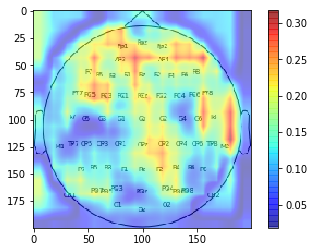

In [12]:
visualize(avg_sm_slow)

In [8]:
avg_sm_med = get_avg_saliency_map(model, X_medium, top_medium)
pickle.dump(avg_sm_med, open("avg_sm_med.pkl", "wb"))

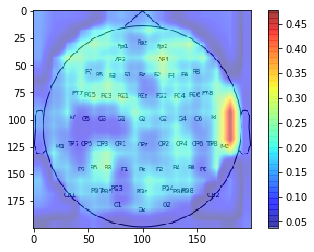

In [8]:
visualize(avg_sm_med)

In [5]:
avg_sm_fast = get_avg_saliency_map(model, X_fast, top_fast)
pickle.dump(avg_sm_fast, open("avg_sm_fast.pkl", "wb"))

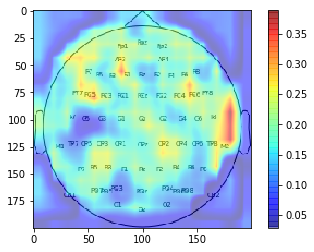

In [7]:
visualize(avg_sm_fast)

In [27]:
avg_sm_slow = pickle.load(open("avg_sm_slow.pkl", "rb"))
avg_sm_med = pickle.load(open("avg_sm_med.pkl", "rb"))
avg_sm_fast = pickle.load(open("avg_sm_fast.pkl", "rb"))
sms = np.dstack((avg_sm_slow, avg_sm_med, avg_sm_fast))
sms = sms/np.max(sms)

In [54]:
np.median(sms)

0.28782396945437916

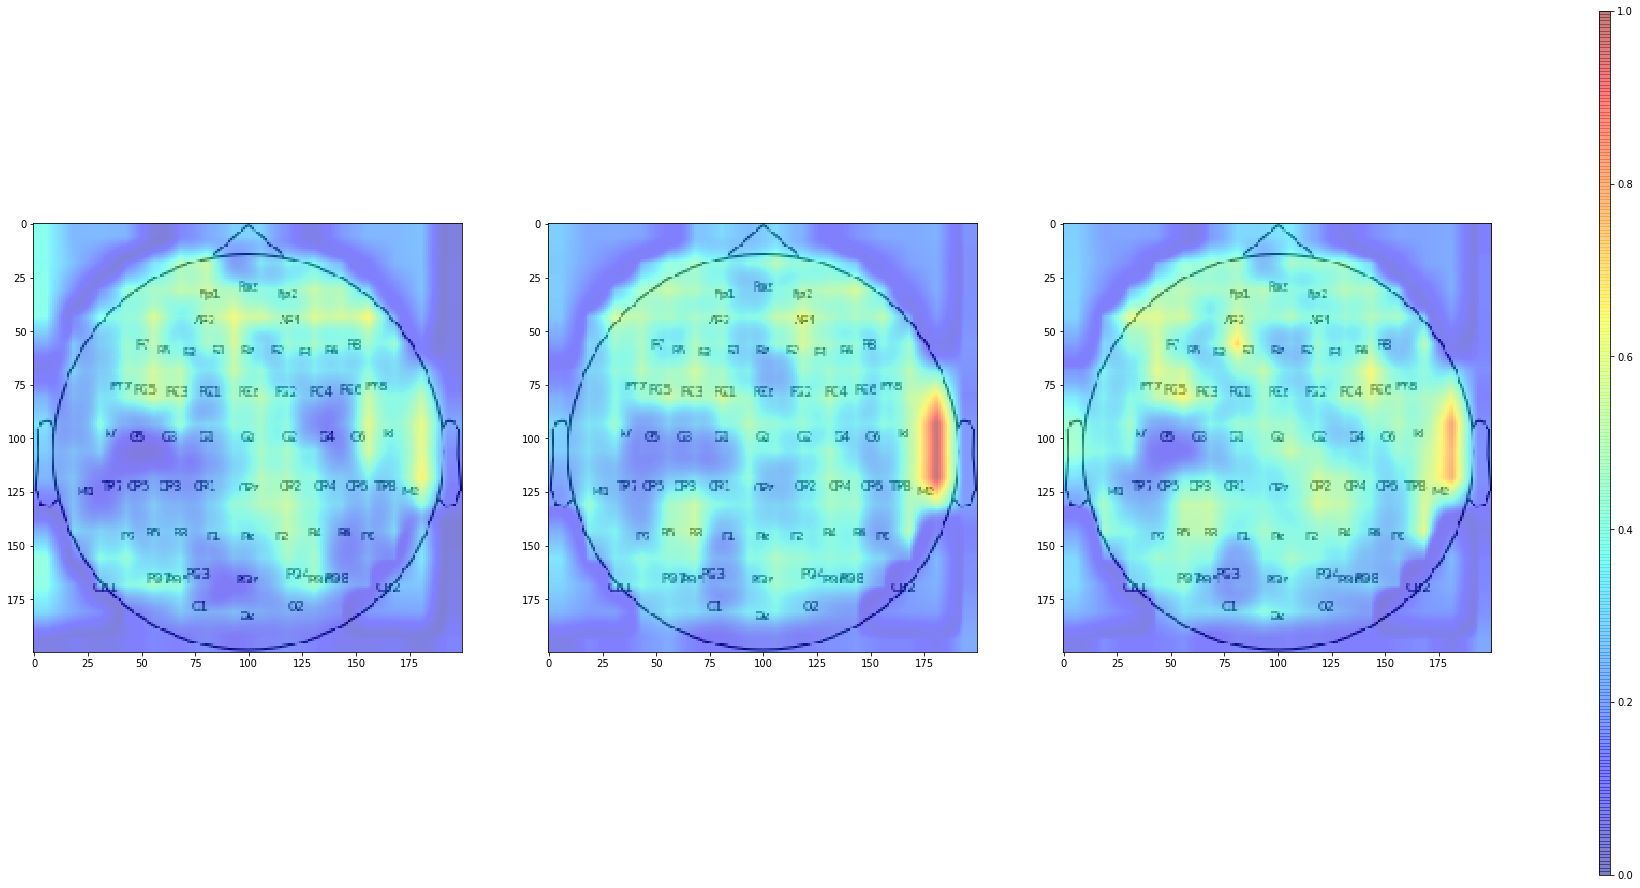

In [74]:
from matplotlib import cm
x = image.load_img("r_64_ch_topomap.png", target_size=(200, 200))
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30,30))

for i in range(3):
    axs[i].imshow(x)
    im = axs[i].imshow(sms[:,:,i], alpha=0.5, cmap=cm.jet, vmin=0, vmax=1)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.005, 0.4])
fig.colorbar(im, cax=cbar_ax)

plt.show()

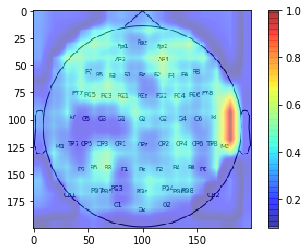

In [76]:
plt.figure()
plt.imshow(x)
plt.imshow(sms[:,:,1], cmap='jet', alpha=0.5)
plt.colorbar()